# Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reading the dataset

In [3]:
customer_data = pd.read_csv('D:/DATA/Desktop/bigData/final_project/work/data/Churn_Modelling.csv')

dataset = customer_data.copy()

# Exploratory Data Analysis

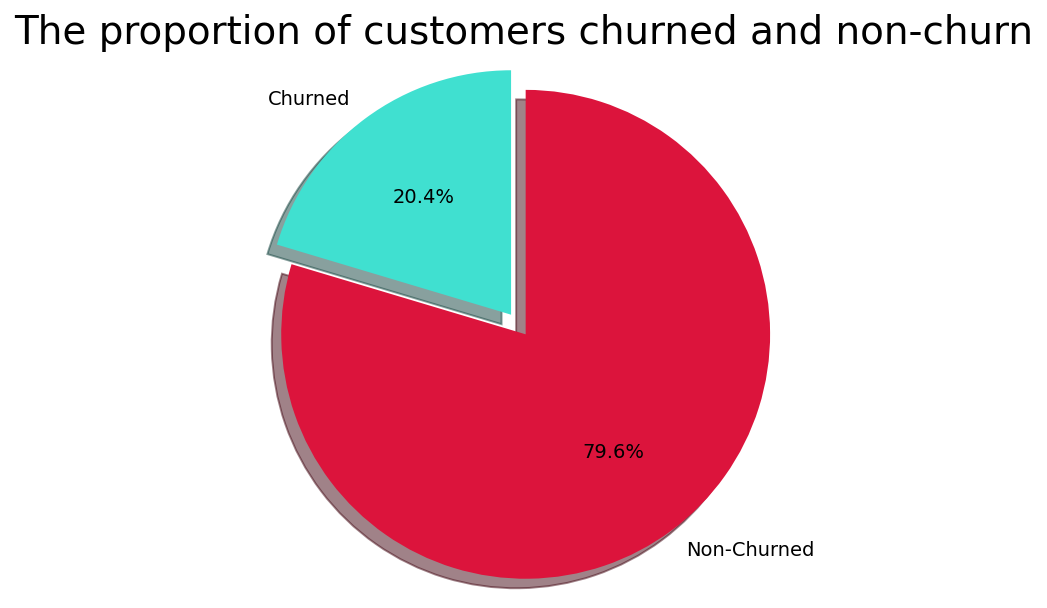

In [4]:
labels = 'Churned', 'Non-Churned'
sizes = [dataset.Exited[dataset['Exited'] == 1].count(), dataset.Exited[dataset['Exited'] == 0].count()]
colors = ["turquoise", "crimson"]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize = (5, 5), dpi = 140)
ax1.pie(sizes, explode = explode, labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True, startangle = 90)
ax1.axis('equal')
plt.title("The proportion of customers churned and non-churn", size = 20)
plt.savefig('Pieplot.png')
plt.show()

In [5]:
non_churn = dataset[dataset['Exited'] == 0]['Exited'].count()
churn = dataset[dataset['Exited'] == 1]['Exited'].count()
print("non_churn: ", non_churn, "\nchurn: ", churn)

non_churn:  7963 
churn:  2037


# Determine the outliers

In [6]:
import pandas as pd

# Droping the ineffective columns
df = customer_data[['CreditScore', 'Age', 'NumOfProducts']]

# Function to detect outliers and compute the average of outlier values
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Get outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]

    # Compute average of outliers (if any exist)
    avg_outlier = outliers.mean() if not outliers.empty else None
    
    if avg_outlier < lower_bound:
        outlier = max(outliers)
    elif avg_outlier > upper_bound:
        outlier = min(outliers)
    
    return  lower_bound, upper_bound, outliers, outlier

# Apply the function to all numerical features
outliers_summary = {col: detect_outliers_iqr(df, col) for col in df.select_dtypes(include="number").columns}

# Display results
for feature, (lower_bound, upper_bound, outliers, outlier) in outliers_summary.items():
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Outliers: {len(outliers)}")
    print(f"Expected Outlier Value: {outlier}")
    print("-" * 50)

Feature: CreditScore
Lower Bound: 383.0
Upper Bound: 919.0
Number of Outliers: 15
Expected Outlier Value: 382
--------------------------------------------------
Feature: Age
Lower Bound: 14.0
Upper Bound: 62.0
Number of Outliers: 359
Expected Outlier Value: 63
--------------------------------------------------
Feature: NumOfProducts
Lower Bound: -0.5
Upper Bound: 3.5
Number of Outliers: 60
Expected Outlier Value: 4
--------------------------------------------------


# Distribution of the continuous variables

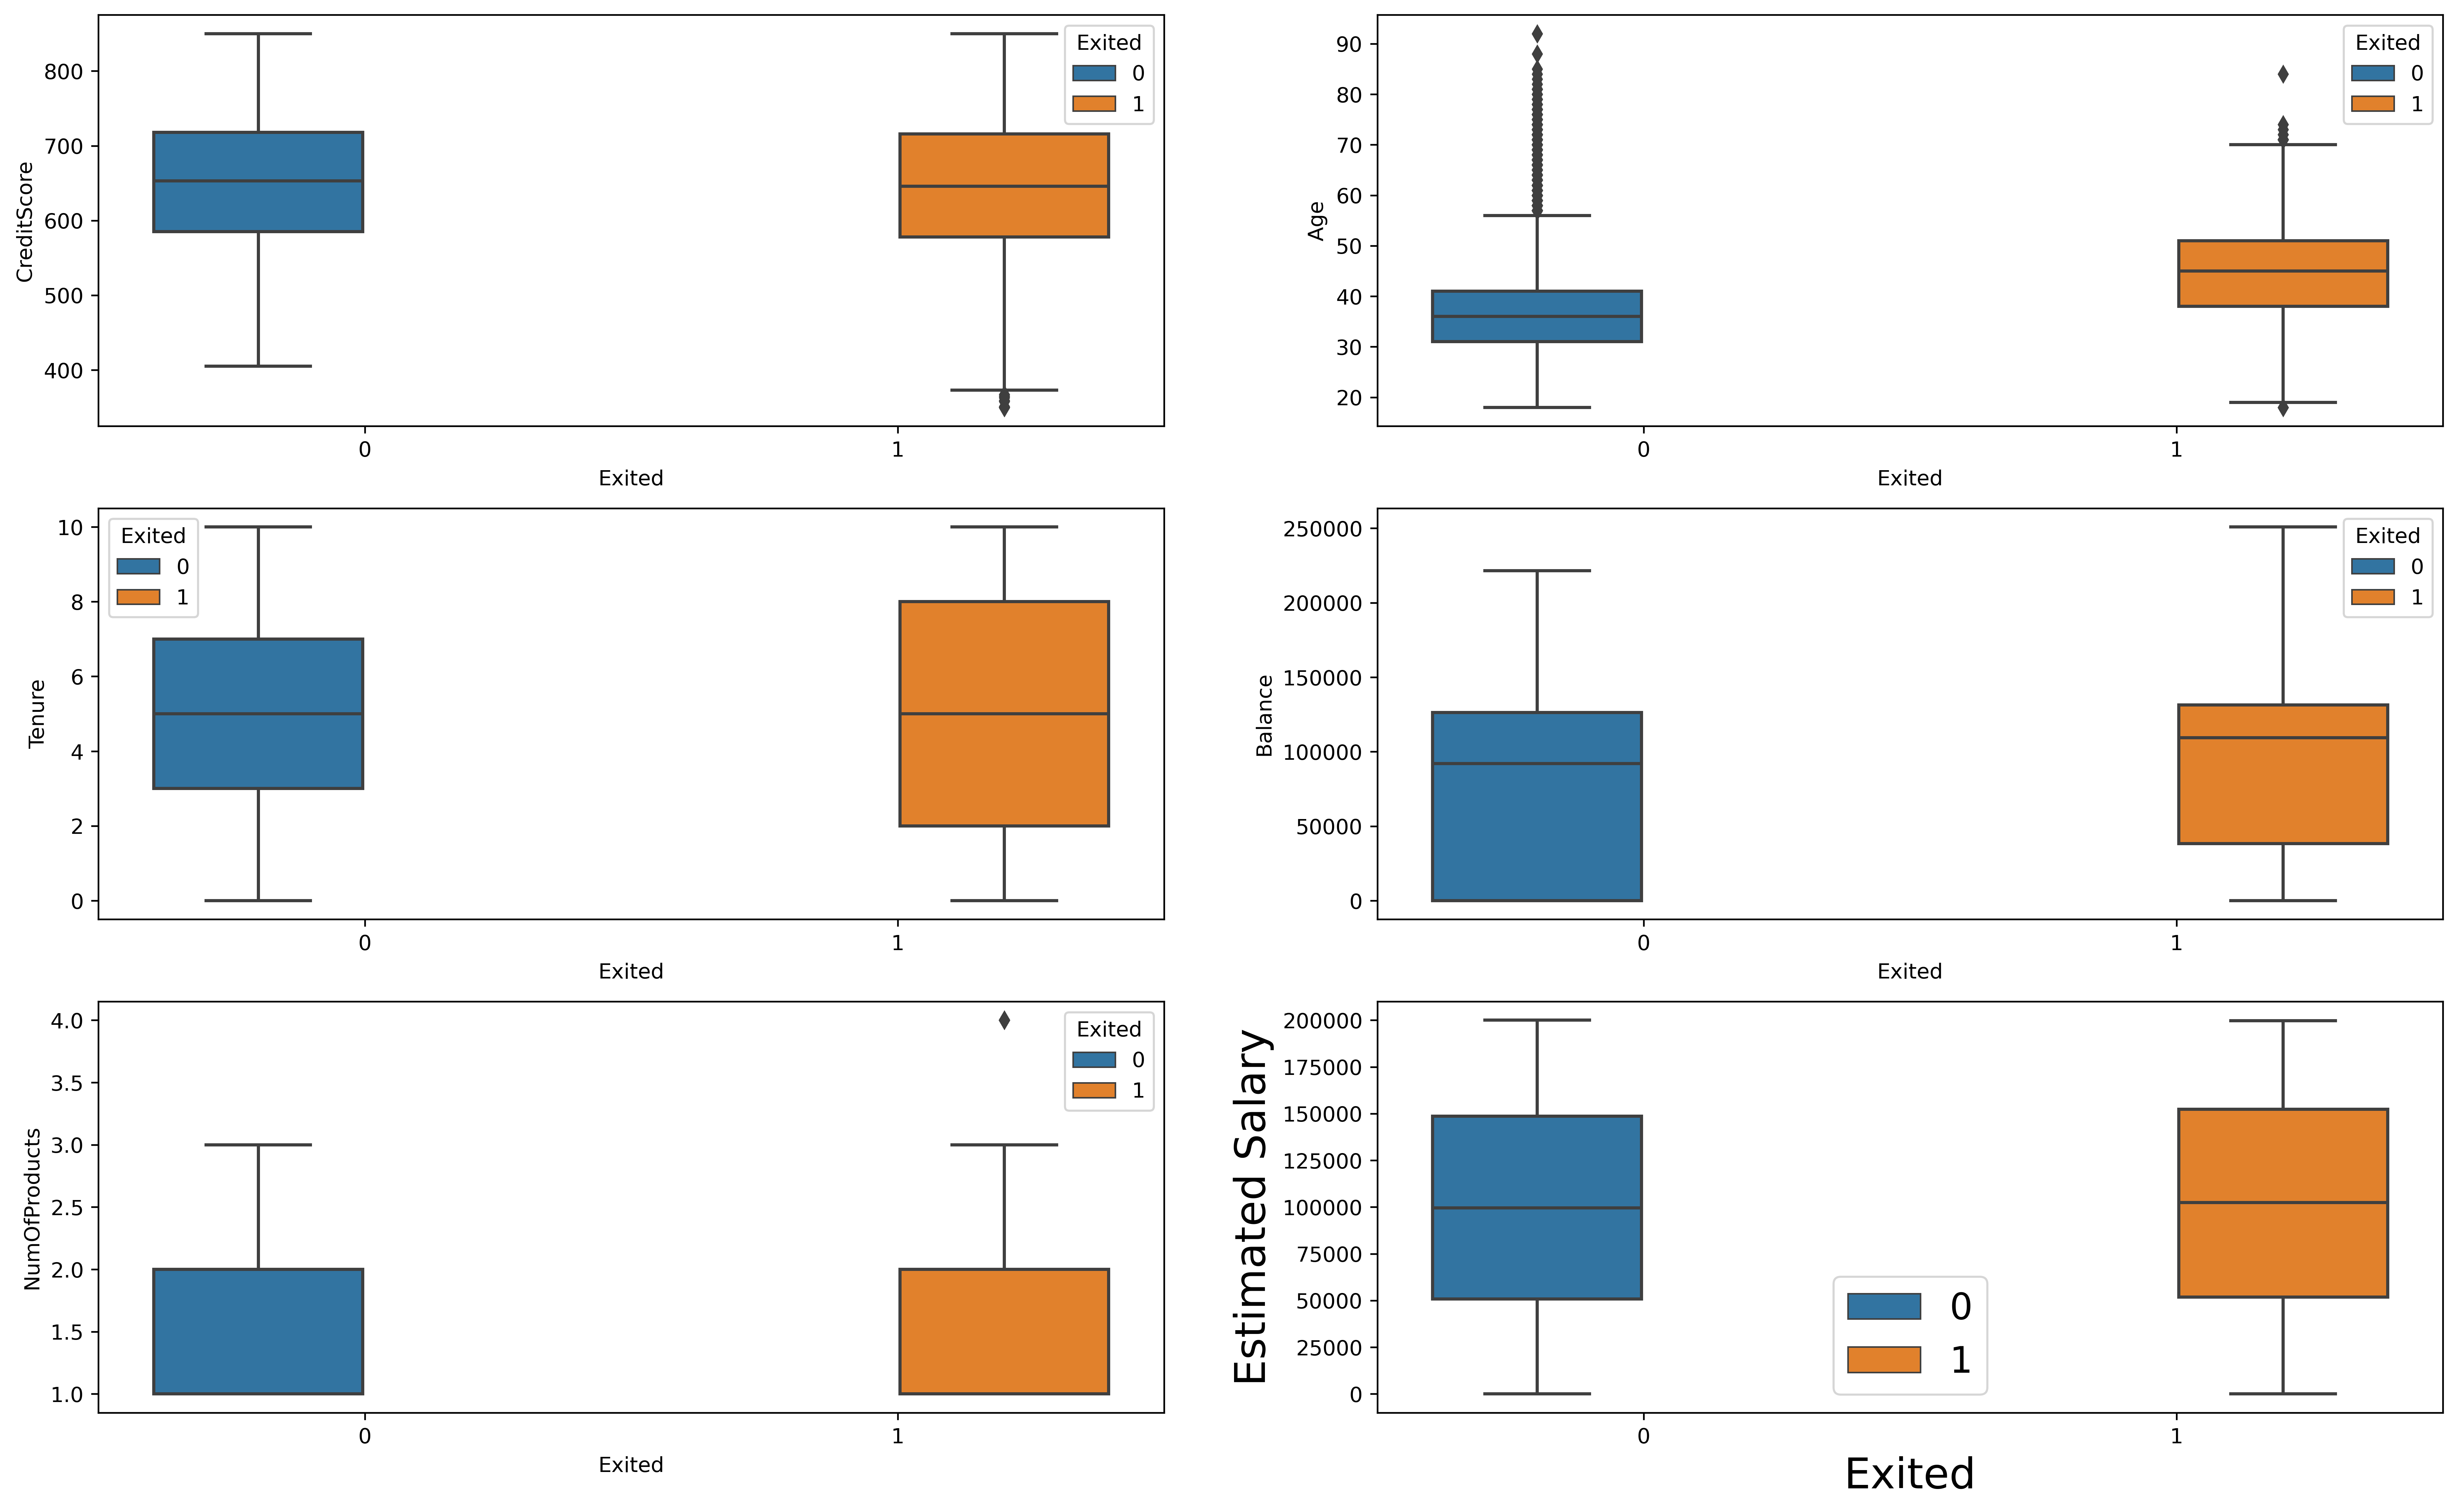

In [7]:
fig, axarr = plt.subplots(3, 2, figsize = (20, 12), dpi = 480)
sns.boxplot(y = 'CreditScore', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[0][0])
sns.boxplot(y = 'Age', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[0][1])
sns.boxplot(y = 'Tenure', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[1][0])
sns.boxplot(y = 'Balance', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[1][1])
sns.boxplot(y = 'NumOfProducts', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[2][0])
sns.boxplot(y = 'EstimatedSalary', x = 'Exited', hue = 'Exited', data = dataset, ax = axarr[2][1])

plt.xlabel('Exited', fontsize = 20, color = 'black')
plt.ylabel('Estimated Salary', fontsize = 20, color = 'black')
plt.legend(fontsize = "xx-large")
plt.savefig('ContinuousVariables.png')

# Remove the outliers

In [8]:
dataset.drop(dataset[dataset['CreditScore'] <= 382].index, inplace = True)

dataset.drop(dataset[dataset['Age'] >= 63].index, inplace = True)

dataset.drop(dataset[dataset['NumOfProducts'] >= 4].index, inplace = True)

# Shape of Data after removing the outliers
print("Shape of Data after removing outliers: {}".format(dataset.shape))

Shape of Data after removing outliers: (9568, 14)


# Feature engineering

In [9]:
dataset['BalanceSalary'] = dataset.Balance / dataset.EstimatedSalary
dataset['TenureAge'] = dataset.Tenure / (dataset.Age)
dataset['ScoreAge'] = dataset.CreditScore / (dataset.Age)

dataset['tenure_age'] = dataset.Tenure / (dataset.Age - 17)
dataset['tenure_salary'] = dataset.Tenure / (dataset.EstimatedSalary)
dataset['score_age'] = dataset.CreditScore / (dataset.Age - 17)
dataset['score_salary'] = dataset.CreditScore / (dataset.EstimatedSalary)

dataset["newAge"] = dataset["Age"] - dataset["Tenure"]
dataset["newCreditScore"] = pd.qcut(dataset['CreditScore'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dataset["AgeScore"] = pd.qcut(dataset['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
dataset["BalanceScore"] = pd.qcut(dataset['Balance'].rank(method = "first"), 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dataset["SalaryScore"] = pd.qcut(dataset['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dataset["newEstimatedSalary"] = dataset["EstimatedSalary"] / 12 

dataset['score_balance'] = dataset.Balance / (dataset.CreditScore)
dataset['age_balance'] = dataset.Balance / (dataset.Age)
dataset['balance_salary'] = dataset.Balance / (dataset.EstimatedSalary)
dataset['age_hascrcard'] = dataset.HasCrCard / (dataset.Age)

In [10]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if number_of_products == 0:
        return 0
    if tenure == 0:
        return number_of_products
    
    rate = number_of_products / tenure
    return rate

def product_utilization_rate_by_salary(row):
    number_of_products = row.NumOfProducts
    estimated_salary = row.EstimatedSalary
    
    if number_of_products == 0:
        return 0
    
    rate = number_of_products / estimated_salary
    return rate

def countries_monthly_average_salaries(row):
    fr = 3696    
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography
    
    if country == "Germany":
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain": 
        return salary / sp

In [11]:
def feature_engineering(cus, is_show_graph = False):
    df_fe = dataset.copy()
    
    # product usage rate by year
    df_fe = df_fe.assign(product_utilization_rate_by_year = df_fe.apply(lambda x: product_utilization_rate_by_year(x), axis = 1))
    
    # product usage rate by estimated salary
    df_fe = df_fe.assign(product_utilization_rate_by_salary = df_fe.apply(lambda x: product_utilization_rate_by_salary(x), axis = 1)) 
    
    # average monthly salary according to countries
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis = 1))
    
    return df_fe

In [12]:
df_fe = feature_engineering(dataset)
df_fe

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,BalanceScore,SalaryScore,newEstimatedSalary,score_balance,age_balance,balance_salary,age_hascrcard,product_utilization_rate_by_year,product_utilization_rate_by_salary,countries_monthly_average_salaries
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,...,1,6,8445.740000,0.000000,0.000000,0.000000,0.023810,0.500000,0.000010,2.285103
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,...,5,6,9378.548333,137.841875,2044.094146,0.744677,0.000000,1.000000,0.000009,4.155316
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,...,10,6,9494.297500,318.049402,3801.447619,1.401375,0.023810,0.375000,0.000026,2.568803
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,...,1,5,7818.885833,0.000000,0.000000,0.000000,0.000000,2.000000,0.000021,2.115499
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,...,8,4,6590.341667,147.659788,2918.856279,1.587055,0.023256,0.500000,0.000013,2.919956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,...,4,5,8022.553333,0.000000,0.000000,0.000000,0.025641,0.400000,0.000021,2.170604
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,...,4,6,8474.980833,111.181415,1639.131714,0.564108,0.028571,0.100000,0.000010,2.293014
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,...,4,3,3507.131667,0.000000,0.000000,0.000000,0.000000,0.142857,0.000024,0.948899
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,...,5,5,7740.710000,97.247811,1787.507381,0.808230,0.023810,0.666667,0.000022,1.633061


In [13]:
from sklearn.preprocessing import LabelEncoder

# Converting inputs to numeric values
encoder = LabelEncoder()
df_fe["Geography"] = encoder.fit_transform(df_fe["Geography"])
df_fe["Gender"] = encoder.fit_transform(df_fe["Gender"])

# Encoding categorical data
df_fe = df_fe.drop(['Geography', 'Gender'], axis = 1)
Geography = pd.get_dummies(dataset.Geography, drop_first = True)
Gender = pd.get_dummies(dataset.Gender).iloc[:, 0:]

In [15]:
# Data merging
df_fe = pd.concat([df_fe, Geography, Gender], axis = 1)
df_fe.to_csv('D:/DATA/Desktop/bigData/final_project/work/data/Churn_Modelling_FE.csv', index = False)
df_fe

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,product_utilization_rate_by_salary,countries_monthly_average_salaries,Germany,Spain,Female,Male,Germany,Spain,Female,Male
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,...,0.000010,2.285103,False,False,True,False,False,False,True,False
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,...,0.000009,4.155316,False,True,True,False,False,True,True,False
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,...,0.000026,2.568803,False,False,True,False,False,False,True,False
3,4,15701354,Boni,699,39,1,0.00,2,0,0,...,0.000021,2.115499,False,False,True,False,False,False,True,False
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,...,0.000013,2.919956,False,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,39,5,0.00,2,1,0,...,0.000021,2.170604,False,False,False,True,False,False,False,True
9996,9997,15569892,Johnstone,516,35,10,57369.61,1,1,1,...,0.000010,2.293014,False,False,False,True,False,False,False,True
9997,9998,15584532,Liu,709,36,7,0.00,1,0,1,...,0.000024,0.948899,False,False,True,False,False,False,True,False
9998,9999,15682355,Sabbatini,772,42,3,75075.31,2,1,0,...,0.000022,1.633061,True,False,False,True,True,False,False,True
